<a href="https://colab.research.google.com/github/RUMONMD89/Neural-network/blob/main/mnist4_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


11490434/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 softmax (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 3s 4ms/step - loss: 0.7292 - acc: 0.8181 - val_loss: 0.3585 - val_acc: 0.9120
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3820 - acc: 0.8982 - val_loss: 0.2891 - val_acc: 0.9255
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3338 - acc: 0.9090 - val_loss: 0.2648 - val_acc: 0.9275
Epoch 4/10
422/422 [==============================] - 1s 3ms/step - loss: 0.3114 - acc: 0.9145 - val_loss: 0.2510 - val_a

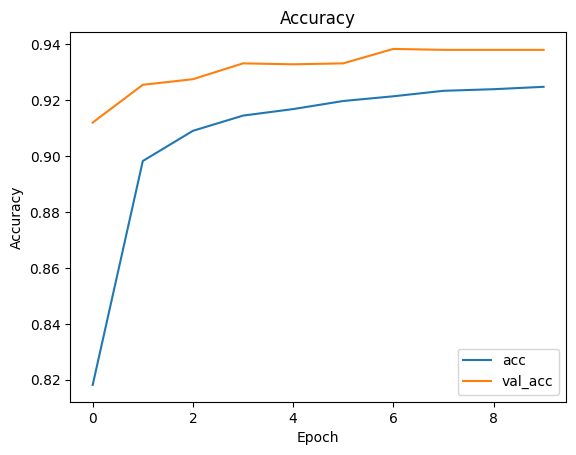

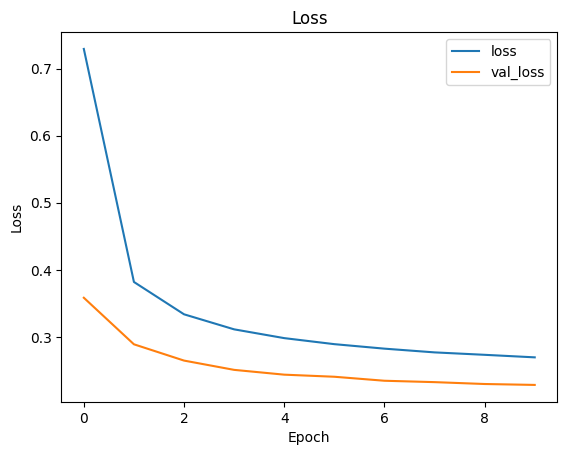

313/313 [==============================] - 1s 2ms/step
Predict  Time [s]= 1.561197280883789
Prediction Accuracy = 0.9257


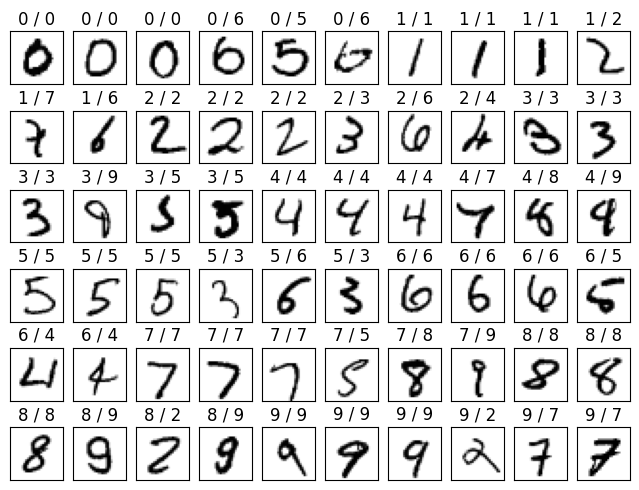

In [ ]:
#!/usr/bin/env python3
#
# _/_/_/ MNIST Sample Ver.4 _/_/_/
# Written  by Etsuji Nakai
# Modified by Y.Hirokawa


### User Settings ###

# NEURAL NETWORK (0:Single Dense Layer / 1:CNN / 2:User Defined)
INETWORK = 0

# Number of epochs (Training)
IEPOCH   = 10

# Ratio of validation/(training+validation)
RATIO    = 0.1

# Seed of pseudo random number
ISEED    = 1

# Graphic Display (0:File Output / 1:Display Window & File Output)
IGRAPHIC = 1

# Result Directory
OUTDIR   = '/content/drive/MyDrive/RESULTS'

# Input Directory of User Test Data (None: Use MNIST / other: Use images in INDIR)
INDIR   = None
#INDIR   = '/content/drive/MyDrive/UPLOAD'


# Use Pre-Trained Data If Exists (0: No / 1:Yes)
ILOAD   = 0

#####################


### Library Declaration ###
import numpy  as np
from   pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow        as tf
from   PIL               import Image, ImageOps
from   tensorflow.keras.callbacks           import CSVLogger, ModelCheckpoint
from   tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from   tensorflow.keras.models import *
from   tensorflow.keras.layers import *
import sys, os
import time
import csv
import argparse
import glob

### MNIST dataset download ###
# Download to ~/.keras/datasets/mnist.npz
from tensorflow.keras.datasets import mnist

### Global Variables ###
dataset = None
result  = None


### User Defined Function ###

# User Defined Model
def udf_model():
    model = Sequential()
    model.add(Reshape((28, 28, 1), input_shape=(28*28,), name='reshape'))
    ### Please modify python code FROM HERE (Please start from column 4) ###

    ### Please modify python code TO HERE  ###
    model.add(Flatten(name='flatten_final'))
    model.add(Dense(10, activation='softmax', name='softmax'))
    return model


# Check Arguments
def checkargs():
    # Gloval vaiables (too many return values...)
    global INETWORK, IEPOCH, ISEED, RATIO, IGRAPHIC, OUTDIR, INDIR, ILOAD

    # Parse Arguments
    parser = argparse.ArgumentParser(description='MNIST Sample Program')
    parser.add_argument('-n','--INETWORK', type=int,   help='NEURAL NETWORK (0:Single Dense Layer / 1:CNN / 2:User Defined)', choices=[0,1,2])
    parser.add_argument('-e','--IEPOCH',   type=int,   help='Number of epochs (Training)')
    parser.add_argument('-r','--RATIO',    type=float, help='Ratio of validation/(training+validation) [0.0-1.0]')
    parser.add_argument('-s','--ISEED',    type=int,   help='Seed of pseudo random number')
    parser.add_argument('-g','--IGRAPHIC', type=int,   help='Graphic Display (0:Only File-output / 1:Display Window & File-output)', choices=[0,1])
    parser.add_argument('-o','--OUTDIR',               help='Result Directory')
    parser.add_argument('-i','--INDIR',                help='Input Directory')
    parser.add_argument('-l','--ILOAD',                help='Use PreTrained Weights/bias')
    args = parser.parse_args()

    if args.INETWORK != None:
        INETWORK = args.INETWORK
    if args.IEPOCH   != None:
        IEPOCH   = args.IEPOCH
    if args.RATIO    != None:
        if args.RATIO >= 0.0  and args.RATIO <=1.0:
            RATIO    = args.RATIO
        else:
            print("[ERROR] RATIO must be range from 0.0 to 1.0.")
            exit
    if args.ISEED    != None:
        ISEED    = args.ISEED
    if args.IGRAPHIC != None:
        IGRAPHIC = args.IGRAPHIC
    if args.OUTDIR   != None:
        OUTDIR   = args.OUTDIR
    if args.INDIR   != None:
        INDIR    = args.INDIR
    if args.ILOAD   != None:
        ILOAD    = args.ILOAD

    ### Print Settings ###
    print("INETWORK =",INETWORK)
    print("IEPOCH   =",IEPOCH)
    print("ISEED    =",ISEED)
    print("RATIO    =",RATIO)
    print("IGRAPHIC =",IGRAPHIC)
    print("OUTDIR   =",OUTDIR)
    print("INDIR    =",INDIR)
    print("ILOAD    =",ILOAD)

    return


# Initialize
def init(ISEED, INETWORK, IEPOCH, RATIO, INDIR):
    ### Disable pycache for safety ###
    sys.dont_write_bytecode = True
    os.environ['PYTHONDONTWRITEBYTECODE']  = '1'

    ### Thread ###
    os.environ['KMP_DUPLICATE_LIB_OK']     = 'TRUE'

    ### Set Seed of Pseudo Random Number ###
    np.random.seed(ISEED)
    tf.random.set_seed(ISEED)

    ### Define Dataset (images and labels) of Training, Inference ###
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    ### User Defined Test Data (28px X 28px)###
    #
    # For exception handling for variable type mismatch
    if INDIR != None:
        print("[INFO] Using user images for test.")
        i = 0
        # Check PNG files
        FILES = glob.glob(INDIR + "/*")
        nf    = len(FILES)
        # Create Numpy Array
        ntmp  = nf*28*28
        tmp_images  = np.empty(ntmp, np.int32)
        test_images = np.reshape(tmp_images, (nf,28,28))
        test_images[:,:,:] = 0.0
        test_labels = np.empty(nf, np.int32)
        test_labels[:]     = 0
        for file in FILES:
            # Image
            image_org = load_img(file, color_mode="grayscale")
            # Resize Image
            image     = image_org.resize(size=(28,28), resample=Image.BICUBIC)
            # Convert to negative
            imagen    = ImageOps.invert(image)
            # Convert Image to Numpy Array
            npimg     = np.array(img_to_array(imagen))
            test_images[i,:,:] = npimg[:,:,0]
            # Label
            tmp = os.path.splitext(os.path.basename(file))[0]
            # Only use the 1st character
            test_labels[i] = tmp[0]
            i += 1

    ### Resize and Normalizations (0-255 -> 0-1) of images ###
    train_images = train_images.reshape((len(train_images), 784)).astype('float32') / 255
    test_images  = test_images.reshape((len(test_images),   784)).astype('float32') / 255

    ### Convert Labels to One Hot Encoding ###
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels  = tf.keras.utils.to_categorical(test_labels,  10)

    return train_images, train_labels, test_images, test_labels


# Define model of neural network architecture
def conv_model(id):

    if(int(id) == 0):
        # Single Dense Layer
        model = Sequential()
        model.add(Dense(10, activation='softmax', input_shape=(28*28, ), name='softmax'))
    elif(int(id) == 1):
        # CNN
        model = Sequential()
        model.add(Reshape((28, 28, 1), input_shape=(28*28,), name='reshape'))
        model.add(Conv2D(32, (3, 3), padding='same', \
                  use_bias=True, activation='relu', name='conv_filter1'))
        model.add(Conv2D(64, (3, 3), padding='same', \
                  use_bias=True, activation='relu', \
                  name='conv_filter2'))
        model.add(Dropout(rate=0.25, name='dropout1'))
        model.add(Flatten(name='flatten'))
        model.add(Dense(128, activation='relu', name='hiden'))
        model.add(Dropout(rate=0.5, name='dropout2'))
        model.add(Dense(10, activation='softmax', name='softmax'))
    else:
        # User Defined Neural Network (Please write or modify python code in def udf_model(model)
        model = udf_model()

    model.summary()
    return model


# Compile
def compile_model(model):
    ### Definition of Optimizor and Loss Function ###
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model


# Training
def fit(model, dataset, IEPOCH, RATIO, IGRAPHIC, ILOAD):
    train_images = dataset[0]
    train_labels = dataset[1]
    test_images  = dataset[2]
    test_labels  = dataset[3]

    # Weights/bias of neural network
    fweight = f"{OUTDIR}/weight_S{ISEED}_N{INETWORK}_E{IEPOCH}_R{RATIO}.hdf5"

    t1 = time.time()
    if not os.path.isfile(fweight)  or  int(ILOAD) == 0:
        # Training and save weights/bias
        stack = model.fit(train_images, train_labels, batch_size=128, epochs=IEPOCH, validation_split=RATIO)
        model.save_weights(fweight)
    else:
        # Use pre-trained weights/bias
        print("[INFO] Loadin pre-trained weights/bias.")
        model.load_weights(fweight)
    t2 = time.time()
    print("Training Time [s]=",t2-t1)

    if int(ILOAD) == 0:
        fig = plt.figure()
        x   = range(IEPOCH)
        plt.plot(x, stack.history['acc'], label="acc")
        plt.plot(x, stack.history['val_acc'], label="val_acc")
        plt.title("Accuracy")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        if(int(IGRAPHIC) == 1):
            plt.show()
        fig.savefig(f"{OUTDIR}/accuracy_S{ISEED}_N{INETWORK}_E{IEPOCH}_R{RATIO}.png")

        fig = plt.figure()
        plt.plot(x, stack.history['loss'], label="loss")
        plt.plot(x, stack.history['val_loss'], label="val_loss")
        plt.title("Loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        if(int(IGRAPHIC) == 1):
            plt.show()
        fig.savefig(f"{OUTDIR}/loss_S{ISEED}_N{INETWORK}_E{IEPOCH}_R{RATIO}.png")

        with open(f'{OUTDIR}/summary_S{ISEED}_N{INETWORK}_E{IEPOCH}_R{RATIO}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Accucary', 'Loss', 'Validation_Accuracy', 'Validation_Loss'])
            for i in range(0,IEPOCH):
                writer.writerow([i, stack.history['acc'][i], stack.history['loss'][i], \
                                 stack.history['val_acc'][i], stack.history['val_loss'][i]])
            writer.writerow(['Training Time', t2-t1, '[s]', None ])

    return model


def prediction(model, dataset):
    train_images = dataset[0]
    train_labels = dataset[1]
    test_images  = dataset[2]
    test_labels  = dataset[3]

    ### Inference (Predition) ###
    t2    = time.time()
    p_val = model.predict(np.array(test_images))
    t3    = time.time()
    print("Predict  Time [s]=",t3-t2)

    ### Check Results ###
    df    = DataFrame({'pred' :list(map(np.argmax, p_val)), \
                   'label':list(map(np.argmax, test_labels))})
    correct   = df[df['pred']==df['label']]
    incorrect = df[df['pred']!=df['label']]

    ac_predict = len(correct)/len(correct+incorrect)
    print("Prediction Accuracy =",ac_predict)

    with open(f'{OUTDIR}/summary_S{ISEED}_N{INETWORK}_E{IEPOCH}_R{RATIO}.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(['Prediction Time', t3-t2, '[s]', None ])
        writer.writerow(['Prediction Accuracy', ac_predict, None, None ])

    return p_val, df, correct, incorrect


def view(dataset, result, ISEED, INETWORK, IEPOCH, RATIO, IGRAPHIC):
    train_images = dataset[0]
    train_labels = dataset[1]
    test_images  = dataset[2]
    test_labels  = dataset[3]
    p_val        = result[0]
    df           = result[1]
    correct      = result[2]
    incorrect    = result[3]

    ### View Results ###
    fig = plt.figure(figsize=(8,6))
    for i in range(10):
        indices =  list(correct[correct['pred']==i].index[:3]) \
                  +list(incorrect[incorrect['pred']==i].index[:3])
        for c, image in enumerate(test_images[indices]):
            subplot = fig.add_subplot(6, 10, i*6+c+1)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.set_title('%d / %d' % (i, df['label'][indices[c]]))
            subplot.imshow(image.reshape((28, 28)), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    if(int(IGRAPHIC) == 1):
        plt.show()
    fig.savefig(f"{OUTDIR}/result_S{ISEED}_N{INETWORK}_E{IEPOCH}_R{RATIO}.png")

    return



### Main Program ###
# CUI mode option (Please comment out for Google Colaboratory)
###checkargs()

# Output Directory
os.makedirs(f"{OUTDIR}", exist_ok=True)

# Initialzation
dataset = init(ISEED, INETWORK, IEPOCH, RATIO, INDIR)

# Define Neural Network Architecture
model   = conv_model(INETWORK)

# Setting for training
model   = compile_model(model)

# Training
model   = fit(model, dataset, IEPOCH, RATIO, IGRAPHIC, ILOAD)

# Inference
result  = prediction(model, dataset)

# Visualize results
view(dataset, result, ISEED, INETWORK, IEPOCH, RATIO, IGRAPHIC)
